In [46]:
import json
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from ultralytics.yolo.utils.plotting import Annotator


/opt/miniconda3/envs/pt113/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [55]:
class DentexDataset:
    def __init__(self, root_dir: Path, train=True, task='quadrant_enumeration'):
        self.root_dir = root_dir
        self.train = train
        self.task = task

        if task not in ['quadrant', 'quadrant_enumeration', 'quadrant_enumeration_disease']:
            raise ValueError(f'Invalid task: {task}')

        if train:
            task_root_dir = self.root_dir / 'training_data' / task
            with open(task_root_dir / f'train_{task}.json') as f:
                self.json_content = json.load(f)
        else:
            task_root_dir = self.root_dir / 'validation_data' / 'quadrant_enumeration_disease'
            self.json_content = None

        self.task_root_dir = task_root_dir
        self.img_paths = list((task_root_dir / 'xrays').glob('*.png'))
        self.img_names = [i.name for i in self.img_paths]

        image_id_dict = {i['id']: i['file_name'] for i in self.json_content['images']}

        annotations = {}
        for annotation in self.json_content['annotations']:
            image_id = annotation['image_id']
            image_name = image_id_dict[image_id]
            bbox = self.xywh_to_xyxy(annotation['bbox'])
            name = f'{annotation["category_id_1"] + 1}{annotation["category_id_2"] + 1}'

            if image_name not in annotations.keys():
                annotations[image_name] = {}

            annotations[image_name][name] = np.array(bbox)

        self.annotations = annotations

    def plot(self, image_name):
        im = cv2.imread(str(self.task_root_dir / 'xrays' / image_name))

        annotator = Annotator(im, line_width=3, example=image_name)
        for tooth_number, xyxy in self.annotations[image_name].items():
            annotator.box_label(xyxy, str(tooth_number), color=(255, 0, 0))

        im1 = annotator.result()
        plt.imshow(im1)
        plt.show()

    @staticmethod
    def xywh_to_xyxy(box):
        """Converts a bounding box from xywh format to xyxy format.

        Args:
        box: A list of four numbers, representing the bounding box in xywh format.

        Returns:
        A list of four numbers, representing the bounding box in xyxy format.
        """
        x, y, w, h = box
        return [x, y, x + w, y + h]


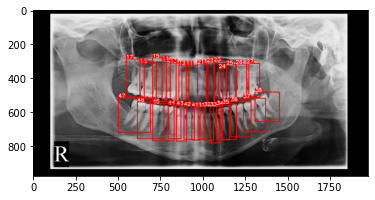

In [56]:
load_dotenv()
data_dir = Path(os.getenv('DATASET_DIR')) / 'DENTEX CHALLENGE 2023'

a = DentexDataset(root_dir=data_dir)

# a.annotations
a.plot('train_172.png')
